In [1]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit

In [2]:
# set-up for query to GAIA archive
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
for table in (tables):
     print (table.get_qualified_name())

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Retrieving tables...
Parsing tables...
Done.
external.external.gaiadr2_geometric_distance
public.public.dual
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour
gaiadr1.gaiadr1.ppmxl_neighbourhood
gaiadr1.gaiadr1.sdss_dr9_best_neighbour
gaiadr1.gaiadr1.sdss_dr9_neighbourhood
gaiadr1.gaiadr1.tmass_best_neighbour
gaiadr1.gaiadr1.tmass_neighbourhood
gaiadr1.gaiadr1.ucac4

In [4]:
# send request to GAIA archive
# the items in the box command are (corrdinate system, RA in deg, Dec in 
#deg, box width in RA and Dec in deg)
query = "SELECT * \
FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, \
gaiadr1.tmass_original_valid AS tmass \
WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid \
AND CONTAINS(POINT('ICRS',g.ra,g.dec),BOX('ICRS',277.49,-1.00,5.,5.))=1 AND (parallax >=1.7 AND parallax_over_error >=3);"

In [5]:
job1 = Gaia.launch_job_async(query, dump_to_file=False)
# this retrieves the result from the query above and puts into a table with the name "p"
# The next line prints out the labels for all of the columns in the table
pp = job1.get_results()
print (pp.colnames)

Query finished.


NameError: name 'p' is not defined

In [6]:
print (pp.colnames)

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

27668
Number of sources in distance range: 6057
6057


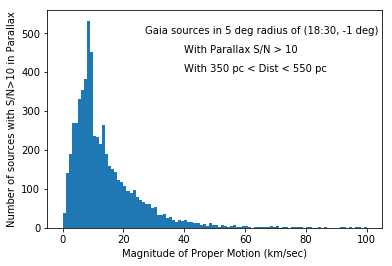

In [7]:
#define variables
ra_big = pp["ra"]
dec_big = pp["dec"]
par_big = pp["parallax"]
pare_big = pp["parallax_error"]
parsn_big = pp["parallax_over_error"]
pmra_big = pp["pmra"]
pmdec_big = pp["pmdec"]
print(len(ra_big))

#count number of sources in distance range
nn = 0
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if(dist > 350. and dist <550. and parsn_big[i]>10.):
         nn = nn + 1
print("Number of sources in distance range:", nn)


secperyr = 60*60*24*365.25
to_kms = 443./1000. * 1.496e8/secperyr

#find magnitude of proper motion for sources with S/N greater than 10 in parallax
pm_mag = np.zeros(0)
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if(dist > 350. and dist <550. and parsn_big[i]>10.):
         pm2 = pmra_big[i]*pmra_big[i] + pmdec_big[i]*pmdec_big[i]
         pm = np.power(pm2,0.5)
         pm_mag = np.append(pm_mag,pm)
print(len(pm_mag))

#create histogram of number of sources for each proper motion magnitude
plt.hist(pm_mag,bins=100,range=(0,100))
plt.xlabel("Magnitude of Proper Motion (km/sec)")
plt.ylabel("Number of sources with S/N>10 in Parallax")
plt.text(27,500,"Gaia sources in 5 deg radius of (18:30, -1 deg)")
plt.text(40,450,"With Parallax S/N > 10")
plt.text(40,400,"With 350 pc < Dist < 550 pc")
plt.savefig("big-Serp-pms.png")
plt.show()